# COMP30027 Machine Learning Assignment 2

### Project 2: How long does it take to cook this? 
**Task:** Build a classifier to predict cooking time of recipes

**Author:** Tuan Khoi Nguyen - 1025294. 
Hai Hong Tran    - 1012919

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os
import pandas as pd
import numpy as np
import re
import time
import pickle
from scipy.sparse import load_npz


from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets, svm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectPercentile, SelectKBest, SelectFpr, chi2, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.impute import  SimpleImputer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from mlxtend.classifier import StackingCVClassifier


from tqdm import tqdm,trange
from collections import defaultdict,Counter
from text_to_num import text2num,alpha2digit

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

## Part 0: Data preprocessing method selection

In [20]:
def preprocess(file, 
               process = None,              # Specified directory other than the original data folder?
               convert_to_seconds = False,  # NLP conversion to get cooking time in seconds?
               k_best = None,               # Pick k best words as k new attributes
               test_or_train = None,        # If pick k best, will it pick from test or train's CountVectorizer?
               out_csv = None               # Export to a csv input file to avoid reusage. Input is the output name
               ):
    curr_dir = os.path.dirname(os.path.realpath('__file__'))
    if not process:
        directory = os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\')
    else:
        directory = os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\recipe_text_features_' + process + '\\')

    data = pd.read_csv(directory+file, index_col = False)

    if convert_to_seconds:
        tqdm.pandas(desc="Converting...")
        data['seconds'] = data['steps'].progress_apply(convert_step_to_time)

    if k_best and test_or_train:
        train_data = pd.read_csv(directory+re.sub(r'test',r'train',file), index_col = False)
        y = train_data['duration_label']
        name, ingr, steps = read_pkl_file(['train_name_countvectorizer.pkl', 'train_ingr_countvectorizer.pkl', 'train_steps_countvectorizer.pkl'])
        x2 = SelectKBest(chi2, k=k_best)
        X_train = steps.fit_transform(train_data['steps'])
        X_train_x2 = x2.fit_transform(X_train,y)

        correlated_words = []
        for feat_num in tqdm(x2.get_support(indices=True), desc = 'Getting top words...', position=0):
            correlated_words.append(steps.get_feature_names()[feat_num])

        npz = load_npz('COMP30027_2021_Project2_datasets\\recipe_text_features_countvec\\' + test_or_train + '_steps_vec.npz')
        train_steps = train_data['steps']

        v = CountVectorizer(stop_words='english').fit(train_steps)
        for word in tqdm(correlated_words, desc = 'Creating rows...', position=0):
            data[word + '?']=[bool(npz[(i,v.vocabulary_[word])]) for i in range(len(data))]
        data = data.drop(['name', 'steps', 'ingredients'], axis=1)

    if out_csv:
        data.to_csv('COMP30027_2021_Project2_datasets\\input\\' + out_csv, index=False)

    return data

In [3]:
def read_pkl_file(files_name):
    file_paths = []
    for file_name in files_name:
        curr_dir = os.path.dirname(os.path.realpath('__file__'))
        file_paths.append(os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\recipe_text_features_countvec\\', file_name))
    
    name = pickle.load(open(file_paths[0], "rb"))
    ingr = pickle.load(open(file_paths[1], "rb"))
    steps = pickle.load(open(file_paths[2], "rb"))
    return name, ingr, steps


def read_npz_file(files_name, use_scipy = True):
    file_paths = []
    for file_name in files_name:
        curr_dir = os.path.dirname(os.path.realpath('__file__'))
        file_paths.append(os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\recipe_text_features_countvec\\' , file_name))
    
    if use_scipy:
        names = scipy.sparse.load_npz(file_paths[0])
        ingr = scipy.sparse.load_npz(file_paths[1])
        steps = scipy.sparse.load_npz(file_paths[2])
        return names, ingr, steps
    
    npz_names = np.load(file_paths[0])
    names = pd.DataFrame.from_dict({i: npz_names[i] for i in npz_names.files}, orient='index')

    npz_ingr = np.load(file_paths[1])
    ingr = pd.DataFrame.from_dict({i: npz_ingr[i] for i in npz_ingr.files}, orient='index')

    npz_steps = np.load(file_paths[2])
    steps = pd.DataFrame.from_dict({i: npz_steps[i] for i in npz_steps.files}, orient='index')
    return names,ingr,steps

def read_train_file(preprocess_method, files_name):
    file_paths = []
    for file_name in files_name:
        curr_dir = os.path.dirname(os.path.realpath('__file__'))
        file_paths.append(os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\', preprocess_method, file_name))
    
    names = pd.read_csv(file_paths[0], index_col = False, delimiter = ',', header=None)
    ingr = pd.read_csv(file_paths[1], index_col = False, delimiter = ',', header=None)
    steps = pd.read_csv(file_paths[2], index_col = False, delimiter = ',', header=None)
    
    return names, ingr, steps

In [6]:
time_retrieval = lambda words, sentence : re.findall(re.compile('|'.join(
        [n + w + "\\b" for w in words for n in ["[0-9]+\s*","another ","few ","a ","an ","several "]])), sentence)

kw_retrieval = lambda words, sentence : re.findall(re.compile('|'.join(
        ["\\b" + w + "\\b" for w in words])), sentence)

def convert_step_to_time(step, keyword_check = True):
    total_time = 0 # in seconds
    times = defaultdict(list)
    time_unit = {"second":1, "minute":60, "hour":60*60}
    kw_dict = {"overnight":8, "night":8, "nights":8, "freeze":5, "refrigerate":3,
               "day":12, "cook on low":7, "slow cook":7, "crockpot":7, "crock pot":7,
               "cook low":7, "boil":1, "heat":1, "bread machine":1.5
               }
    
    # Iterate through each step to find time value using RE
    numeric_step = alpha2digit(step,'en')
    times["second"] = time_retrieval(["more seconds","more second","more secs","more sec","seconds","second","secs","sec","s"],numeric_step)
    times["minute"] = time_retrieval(["more minutes","more minute","more min","more mins","minutes","minute","min","mins","m","ms"],numeric_step)
    times["hour"] = time_retrieval(["more hours","more hour","more hrs","more hr","hours","hour","hrs","hr","h","hs"],numeric_step)
    special_keywords = kw_retrieval(kw_dict.keys(),numeric_step) if keyword_check else None

    for unit in time_unit.keys():
        #total_time += sum([float(re.findall(r'[0-9]+',t.split()[0])[0]) * time_unit[unit] for t in times[unit]])
        count = 0
        for t in times[unit]:
            numerator = t.split()[0]

            if numerator in ["another","a","an"]:
                count = 1
            elif numerator in ["few","several"]:
                count = 4
            else:
                count = float(re.findall(r'[0-9]+',numerator)[0])

            total_time += count * time_unit[unit]

    if keyword_check and not total_time and special_keywords:
        total_time += 60*60*kw_dict[special_keywords[0]]

    if total_time == 0:
        return None
    return total_time

## Preprocess files for later use

In [21]:
warnings.simplefilter("ignore", category=UserWarning)
# Train - Top 50
preprocess('recipe_train.csv', k_best=50, test_or_train='train', out_csv='train_top50.csv')

Creating rows...: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]


n_steps  n_ingredients  duration_label    20?    25?    30?    35?  \
0            6             12             2.0  False  False  False   True   
1            9              5             2.0   True  False  False  False   
2           15             10             2.0  False  False   True   True   
3           10              8             2.0  False  False  False  False   
4            6              5             2.0  False  False  False  False   
...        ...            ...             ...    ...    ...    ...    ...   
39995        6             13             1.0  False  False  False  False   
39996       15             16             2.0   True  False   True  False   
39997        5              8             1.0  False  False  False  False   
39998        7             17             2.0   True   True   True  False   
39999        6             11             2.0  False  False   True  False   

        350?    40?    45?  ...  potatoes?  pour?  preheat?  remove?  ribs?  \
0      False  False  False  ...      False  False     False    False  False   
1      False  False  False  ...      False  False     False    False  False   
2      False  False  False  ...      False  False     False     True  False   
3      False   True  False  ...      False  False     False    False  False   
4      False  False  False  ...      False  False     False    False  False   
...      ...    ...    ...  ...        ...    ...       ...      ...    ...   
39995  False  False  False  ...      False  False     False    False  False   
39996   True   True  False  ...       True  False      True    False  False   
39997  False  False  False  ...      False  False     False    False  False   
39998  False   True  False  ...       True  False     False    False  False   
39999  False  False   True  ...      False   True     False    False  False   

       roast?  setting?  simmer?  slow?  sugar?  
0       False     False     True  False   False  
1       False     False     True  False    True  
2       False     False     True  False   False  
3       False     False     True  False   False  
4       False     False    False  False   False  
...       ...       ...      ...    ...     ...  
39995   False      True    False  False   False  
39996   False     False     True  False   False  
39997   False     False    False  False   False  
39998   False     False     True  False   False  
39999   False     False     True  False   False  

[40000 rows x 53 columns]

In [22]:
# Test - Top 50
preprocess('recipe_test.csv', k_best=50, test_or_train='test', out_csv='test_top50.csv')

Creating rows...: 100%|██████████| 50/50 [00:11<00:00,  4.41it/s]


n_steps  n_ingredients    20?    25?    30?    35?   350?    40?    45?  \
0           9             13   True  False  False  False  False  False  False   
1           3              3  False  False  False  False  False  False  False   
2           8             11  False  False  False  False  False  False  False   
3           9              6  False  False  False  False  False  False  False   
4           9             10  False  False  False  False  False  False  False   
...       ...            ...    ...    ...    ...    ...    ...    ...    ...   
9995        6             10  False  False   True  False   True  False  False   
9996        6              9  False  False  False  False  False  False  False   
9997        2              6  False  False  False  False  False  False  False   
9998       10             11  False   True  False  False  False  False  False   
9999       12             13  False  False   True  False   True  False  False   

       add?  ...  potatoes?  pour?  preheat?  remove?  ribs?  roast?  \
0      True  ...       True  False     False     True  False   False   
1     False  ...      False   True     False    False  False   False   
2      True  ...      False  False      True    False  False   False   
3      True  ...      False   True     False    False  False   False   
4      True  ...      False   True     False    False  False    True   
...     ...  ...        ...    ...       ...      ...    ...     ...   
9995  False  ...      False  False     False    False  False   False   
9996   True  ...      False  False     False    False  False   False   
9997  False  ...      False  False     False    False  False   False   
9998  False  ...      False  False     False    False  False   False   
9999   True  ...      False  False      True     True  False   False   

      setting?  simmer?  slow?  sugar?  
0        False     True  False   False  
1        False    False  False   False  
2        False    False  False   False  
3        False    False  False   False  
4        False    False  False   False  
...        ...      ...    ...     ...  
9995     False    False  False   False  
9996     False     True  False   False  
9997     False    False  False   False  
9998     False    False  False   False  
9999     False    False  False   False  

[10000 rows x 52 columns]

In [23]:
# Train - Seconds
preprocess('recipe_train.csv', convert_to_seconds=True, out_csv='train_seconds.csv')

Converting...: 100%|██████████| 40000/40000 [00:53<00:00, 752.10it/s]


name  n_steps  \
0      wi gal s chicken rice stove top dish made heal...        6   
1                                         irish pin oats        9   
2                      cheesy beef   n biscuit casserole       15   
3                                 lemonade chicken  oamc       10   
4                      graham and peanut butter bon bons        6   
...                                                  ...      ...   
39995                        sour cream lemon bread  abm        6   
39996                        americanized shepherd s pie       15   
39997                             new zealand kiwi salsa        5   
39998                  meat and vegetable shepherd s pie        7   
39999  gloria pitzer s famous dave s style secret bbq...        6   

       n_ingredients                                              steps  \
0                 12  ['in saucepan , melt margarine and combine wit...   
1                  5  ['melt 1 tbs butter in a small saucepan over m...   
2                 10  ['brown ground beef , onion and green pepper',...   
3                  8  ['brown chicken in oil', 'combine all ingredie...   
4                  5  ['set almond bark aside', 'mix remaining ingre...   
...              ...                                                ...   
39995             13  ['in a measuring cup , combine sour cream and ...   
39996             16  ['preheat oven to 350 degrees', 'add potatoes ...   
39997              8  ['place the kiwifruit , pomegranate seeds , av...   
39998             17  ['in a large , deep frying pan , heat oil over...   
39999             11  ['mix all ingredients in a saucepan and simmer...   

                                             ingredients  duration_label  \
0      ['margarine', 'olive oil', 'celery', 'onion', ...             2.0   
1      ['butter', 'pinhead oats', 'water', 'half-and-...             2.0   
2      ['ground beef', 'onion', 'green pepper', 'toma...             2.0   
3      ['boneless skinless chicken', 'frozen lemonade...             2.0   
4      ['graham cracker crumbs', 'crunchy peanut butt...             2.0   
...                                                  ...             ...   
39995  ['sour cream', 'lemon juice', 'milk', 'butter'...             1.0   
39996  ['potatoes', 'butter', 'milk', 'olive oil', 'o...             2.0   
39997  ['kiwi fruits', 'pomegranate seeds', 'avocado'...             1.0   
39998  ['oil', 'onions', 'garlic cloves', 'minced bee...             2.0   
39999  ['worcestershire sauce', 'ketchup', 'black cof...             2.0   

       seconds  
0       2400.0  
1       1620.0  
2       2100.0  
3       2400.0  
4       3600.0  
...        ...  
39995   5400.0  
39996   4530.0  
39997   3600.0  
39998   4020.0  
39999   3300.0  

[40000 rows x 7 columns]

In [24]:
# Test - Seconds
preprocess('recipe_test.csv', convert_to_seconds=True, out_csv='test_seconds.csv')

Converting...: 100%|██████████| 10000/10000 [00:12<00:00, 775.05it/s]


name  n_steps  \
0                               fantastic chicken curry        9   
1                                       feta with honey        3   
2                               chocolate brownie bites        8   
3                       flourless banana bread pancakes        9   
4                          roasted chicken  a la orange        9   
...                                                 ...      ...   
9995                     christmas green bean casserole        6   
9996                               chestnuts and prunes        6   
9997                     super simple tropical dressing        2   
9998  vegetarian black bean cakes w  chunky salsa so...       10   
9999                 cannellini bean and sausage gratin       12   

      n_ingredients                                              steps  \
0                13  ['mix flour , salt and pepper together on a sh...   
1                 3  ['with a mortar and pestle or with the bottom ...   
2                11  ['preheat oven to 350f', 'line mini muffin cup...   
3                 6  ['in a small bowl , peel , break , and then ma...   
4                10  ['clean chicken and pat dry', 'sprinkle salt a...   
...             ...                                                ...   
9995             10  ['prepare green beans in microwave until tende...   
9996              9  ['melt butter in large skillet', 'add chestnut...   
9997              6  ['combine all ingredients and chill', 'shake w...   
9998             11  ['put the rinsed beans into a large bowl and m...   
9999             13  ['preheat oven to 350', 'lightly coat a 8 by 1...   

                                            ingredients  seconds  
0     ['flour', 'salt', 'black pepper', 'skinless ch...   1620.0  
1         ['black peppercorns', 'feta cheese', 'honey']      NaN  
2     ['butter', 'semi-sweet chocolate chips', 'coco...    900.0  
3     ['banana', 'eggs', 'vanilla extract', 'walnuts...      NaN  
4     ['roasting chickens', 'sweet onion', 'parsley'...   4800.0  
...                                                 ...      ...  
9995  ['cream of mushroom soup', 'milk', 'soy sauce'...   2700.0  
9996  ['chestnuts', 'butter', 'salt and pepper', 'gr...   1020.0  
9997  ['pineapple juice', 'red wine vinegar', 'olive...      NaN  
9998  ['black beans', 'egg white', 'green onions', '...   1740.0  
9999  ['olive oil', 'italian sweet sausage', 'fennel...   2580.0  

[10000 rows x 6 columns]

### Read given preprocessed text input

Run each code cell below for specified file to be read

**Count vectorizer**

In [7]:
curr_dir = os.path.dirname(os.path.realpath('__file__'))
train_file = os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\recipe_train.csv')

data = pd.read_csv(train_file, index_col = False, delimiter = ',')
y = data['duration_label']

k = 100
name, ingr, steps = read_pkl_file(['train_name_countvectorizer.pkl', 'train_ingr_countvectorizer.pkl', 'train_steps_countvectorizer.pkl'])
x2 = SelectKBest(chi2, k=k)

def feature_evaluation_countvec(X, k):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=30027)

    X_train_x2 = x2.fit_transform(X_train,y_train)
    X_test_x2 = x2.transform(X_test)

    models = [GaussianNB(),
              MultinomialNB(),
              DecisionTreeClassifier(max_depth=1),
#               KNeighborsClassifier(n_neighbors=1),
#               KNeighborsClassifier(n_neighbors=5),
              DecisionTreeClassifier(max_depth=None)]
#             svm.LinearSVC(C=C),
#             svm.SVC(kernel='rbf', gamma=0.7, C=C),
#             svm.SVC(kernel='poly', degree=3, C=C)]
    titles = ['GNB',
              'MNB',
              'one-r',
#               '1-nearest neighbour',
#               '5-nearest neighbour',
              'Decision Tree']
#             'LinearSVC',
#             'SVM with a cubic kernel',
#             'SVM with an RBF kernel']

    for title, model in zip(titles, models):
        print('\n',title, '(with k=',k,'features):')
    
        # x2
        start = time.time()
        model.fit(X_train_x2.todense(), y_train)
        acc = model.score(X_test_x2.todense(), y_test)
        end = time.time()
        t = end - start
        print("x2 \t\t accuracy:",acc, '\t runtime:', t)
        
#X_name = name.fit_transform(data['name'])
print('\nEvaluating Feature \'name\'')
feature_evaluation_countvec(name.fit_transform(data['name']), k)
      
print('\n\nEvaluating Feature \'ingredients\'')
feature_evaluation_countvec(ingr.fit_transform(data['ingredients']), k)
      
print('\n\nEvaluating Feature \'steps\'')
feature_evaluation_countvec(steps.fit_transform(data['steps']), k)


c:\python38\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.21.3 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(



Evaluating Feature 'name'

 GNB (with k= 100 features):
x2 		 accuracy: 0.28825 	 runtime: 0.0998525619506836

 MNB (with k= 100 features):
x2 		 accuracy: 0.62425 	 runtime: 0.08984613418579102

 one-r (with k= 100 features):
x2 		 accuracy: 0.5225 	 runtime: 0.11469244956970215

 Decision Tree (with k= 100 features):
x2 		 accuracy: 0.66225 	 runtime: 1.3932726383209229


Evaluating Feature 'ingredients'

 GNB (with k= 100 features):
x2 		 accuracy: 0.524 	 runtime: 0.09771037101745605

 MNB (with k= 100 features):
x2 		 accuracy: 0.5875 	 runtime: 0.07582545280456543

 one-r (with k= 100 features):
x2 		 accuracy: 0.537 	 runtime: 0.0896596908569336

 Decision Tree (with k= 100 features):
x2 		 accuracy: 0.59475 	 runtime: 0.7638645172119141


Evaluating Feature 'steps'

 GNB (with k= 100 features):
x2 		 accuracy: 0.71275 	 runtime: 0.11469507217407227

 MNB (with k= 100 features):
x2 		 accuracy: 0.6695 	 runtime: 0.11968016624450684

 one-r (with k= 100 features):
x2 		 accuracy

**doc2vec50**

In [6]:
files_name = ['train_name_doc2vec50.csv', 'train_ingr_doc2vec50.csv', 'train_steps_doc2vec50.csv']
name, ingr, steps = read_train_file('recipe_text_features_doc2vec50\\', files_name)

X = [name, ingr, steps]
i = 0
for x in X:
    if i == 0:
        print('Evaluating on Name Feature:')
    elif i == 1:
        print('Evaluating on Ingredient Feature:')
    else:
        print('Evaluating on Steps Feature:')
        
    models = [DummyClassifier(strategy='most_frequent'),
              GaussianNB(),
              LinearSVC(),
              DecisionTreeClassifier(),
              KNeighborsClassifier(),
              LogisticRegression()]

    titles = ['Zero-R',
              'GNB',
              'LinearSVC',
              'Decision Tree',
              'KNN',
              'Logistic Regression']

    for title, model in zip(titles, models):
        start = time.time()
        acc = np.mean(cross_val_score(model, x, y, cv=10))
        end = time.time()
        t = end - start
        print(title, "Accuracy:",acc, '\tRuntime:', t)
    print()
    i = i + 1

Evaluating on Name Feature:
Zero-R Accuracy: 0.5061500000000001 	Runtime: 0.15170693397521973
GNB Accuracy: 0.5792750000000001 	Runtime: 0.6368625164031982
LinearSVC Accuracy: 0.5933 	Runtime: 168.07342791557312
Decision Tree Accuracy: 0.4962000000000001 	Runtime: 60.67592430114746
KNN Accuracy: 0.5768500000000001 	Runtime: 78.62834239006042
Logistic Regression Accuracy: 0.59415 	Runtime: 10.010095119476318

Evaluating on Ingredient Feature:
Zero-R Accuracy: 0.5061500000000001 	Runtime: 0.2634267807006836
GNB Accuracy: 0.5492 	Runtime: 0.7129018306732178


c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC Accuracy: 0.57775 	Runtime: 311.17115592956543
Decision Tree Accuracy: 0.5023499999999999 	Runtime: 49.46821141242981
KNN Accuracy: 0.554625 	Runtime: 61.66242432594299
Logistic Regression Accuracy: 0.5777499999999999 	Runtime: 10.699821949005127

Evaluating on Steps Feature:
Zero-R Accuracy: 0.5061500000000001 	Runtime: 0.21317362785339355
GNB Accuracy: 0.6214999999999999 	Runtime: 0.7152917385101318


c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\py

LinearSVC Accuracy: 0.6481 	Runtime: 343.52033495903015
Decision Tree Accuracy: 0.5521749999999999 	Runtime: 45.36403679847717
KNN Accuracy: 0.631075 	Runtime: 49.20255088806152
Logistic Regression Accuracy: 0.6511 	Runtime: 16.680136919021606



**doc2vec100**

In [103]:
files_name = ['train_name_doc2vec100.csv', 'train_ingr_doc2vec100.csv', 'train_steps_doc2vec100.csv']
name, ingr, steps = read_train_file('recipe_text_features_doc2vec100\\', files_name)

X = [name, ingr, steps]
i = 0
for x in X:
    if i == 0:
        print('Evaluating on Name Feature:')
    elif i == 1:
        print('Evaluating on Ingredient Feature:')
    else:
        print('Evaluating on Steps Feature:')
        
    models = [DummyClassifier(strategy='most_frequent'),
              GaussianNB(),
              LinearSVC(),
              DecisionTreeClassifier(),
              KNeighborsClassifier(),
              LogisticRegression()]

    titles = ['Zero-R',
              'GNB',
              'LinearSVC',
              'Decision Tree',
              'KNN',
              'Logistic Regression']

    for title, model in zip(titles, models):
        start = time.time()
        acc = np.mean(cross_val_score(model, x, y, cv=10))
        end = time.time()
        t = end - start
        print(title, "Accuracy:",acc, '\tRuntime:', t)
    print()
    i = i + 1

Evaluating on Name Feature:
Zero-R Accuracy: 0.5061500000000001 	Runtime: 0.3071775436401367
GNB Accuracy: 0.5730749999999999 	Runtime: 1.132969617843628
LinearSVC Accuracy: 0.607325 	Runtime: 188.9464361667633
Decision Tree Accuracy: 0.492225 	Runtime: 64.57338762283325
KNN Accuracy: 0.576975 	Runtime: 41.29353332519531


c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Logistic Regression Accuracy: 0.6096000000000001 	Runtime: 19.49396586418152

Evaluating on Ingredient Feature:
Zero-R Accuracy: 0.5061500000000001 	Runtime: 0.34408068656921387
GNB Accuracy: 0.54725 	Runtime: 1.42818284034729


c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\py

LinearSVC Accuracy: 0.58235 	Runtime: 423.3654956817627
Decision Tree Accuracy: 0.49355000000000004 	Runtime: 73.16237497329712
KNN Accuracy: 0.5379500000000002 	Runtime: 40.18614101409912
Logistic Regression Accuracy: 0.5824499999999999 	Runtime: 16.332329750061035

Evaluating on Steps Feature:
Zero-R Accuracy: 0.5061500000000001 	Runtime: 0.28224611282348633
GNB Accuracy: 0.603275 	Runtime: 1.347395896911621


c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\py

LinearSVC Accuracy: 0.6658000000000001 	Runtime: 424.7097158432007
Decision Tree Accuracy: 0.53675 	Runtime: 76.39373779296875
KNN Accuracy: 0.57255 	Runtime: 35.4543981552124


c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Logistic Regression Accuracy: 0.6700000000000002 	Runtime: 18.288459539413452



## Top 50 words feature test

In [26]:
data = pd.read_csv("COMP30027_2021_Project2_datasets\\input\\train_top50.csv")
y_train = data['duration_label']
X_train = data.drop('duration_label', axis=1)
X_train

n_steps  n_ingredients    20?    25?    30?    35?   350?    40?  \
0            6             12  False  False  False   True  False  False   
1            9              5   True  False  False  False  False  False   
2           15             10  False  False   True   True  False  False   
3           10              8  False  False  False  False  False   True   
4            6              5  False  False  False  False  False  False   
...        ...            ...    ...    ...    ...    ...    ...    ...   
39995        6             13  False  False  False  False  False  False   
39996       15             16   True  False   True  False   True   True   
39997        5              8  False  False  False  False  False  False   
39998        7             17   True   True   True  False  False   True   
39999        6             11  False  False   True  False  False  False   

         45?   add?  ...  potatoes?  pour?  preheat?  remove?  ribs?  roast?  \
0      False   True  ...      False  False     False    False  False   False   
1      False   True  ...      False  False     False    False  False   False   
2      False  False  ...      False  False     False     True  False   False   
3      False  False  ...      False  False     False    False  False   False   
4      False  False  ...      False  False     False    False  False   False   
...      ...    ...  ...        ...    ...       ...      ...    ...     ...   
39995  False   True  ...      False  False     False    False  False   False   
39996  False   True  ...       True  False      True    False  False   False   
39997  False   True  ...      False  False     False    False  False   False   
39998  False   True  ...       True  False     False    False  False   False   
39999   True  False  ...      False   True     False    False  False   False   

       setting?  simmer?  slow?  sugar?  
0         False     True  False   False  
1         False     True  False    True  
2         False     True  False   False  
3         False     True  False   False  
4         False    False  False   False  
...         ...      ...    ...     ...  
39995      True    False  False   False  
39996     False     True  False   False  
39997     False    False  False   False  
39998     False     True  False   False  
39999     False     True  False   False  

[40000 rows x 52 columns]

In [91]:
import warnings
warnings.filterwarnings("ignore")

models = [DummyClassifier(strategy='most_frequent'),
          GaussianNB(),
          MultinomialNB(),
          LinearSVC(),
          DecisionTreeClassifier(),
          RandomForestClassifier(),
          KNeighborsClassifier(),
          LogisticRegression(),
          AdaBoostClassifier(),
          GradientBoostingClassifier()]
titles = ['Zero-R',
          'GNB',
          'MNB',
          'LinearSVC',
          'Decision Tree',
          'Random Forest',
          'KNN',
          'Logistic Regression',
          'Ada Boosting',
          'Gradient Boosting']
scores = []
times = []

for title, model in zip(titles, models):
    start = time.time()
    acc = np.mean(cross_val_score(model, X_train, y_train, cv=10))
    end = time.time()
    t = end - start
    scores.append(acc)
    times.append(t)
    print(title, "Accuracy:",acc, 'time:', t)
    

Zero-R Accuracy: 0.5061500000000001 time: 0.13463950157165527
GNB Accuracy: 0.727125 time: 1.5673229694366455
MNB Accuracy: 0.704075 time: 1.3623576164245605


KeyboardInterrupt: 

In [81]:
test_data = pd.read_csv("COMP30027_2021_Project2_datasets\\input\\test_top50.csv")
X_test = test_data
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X_train)
X_test = imp.transform(X_test)

In [95]:
models = [LinearSVC(),
          RandomForestClassifier(),
          LogisticRegression(),
          AdaBoostClassifier(),
          GradientBoostingClassifier()]

sclf = StackingCVClassifier(classifiers=models,
                            meta_classifier=DecisionTreeClassifier())

sclf.fit(X_train, y_train)
y_test = sclf.predict(test_data)

In [96]:
out = pd.DataFrame({'duration_label':y_test})
out.index += 1
out.to_csv('output/out_'+'Hai'+'.csv',index_label = 'id')

## New feature evaluation

In [ ]:
data = pd.read_csv("COMP30027_2021_Project2_datasets\\input\\train_seconds.csv")

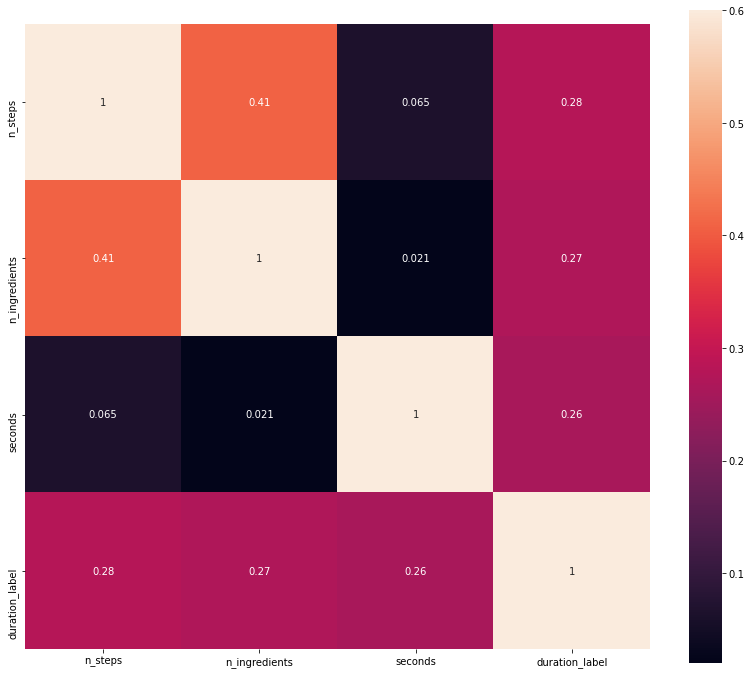

In [95]:
plt.figure(figsize=(14,12))
# foo = sns.heatmap(data.drop('PassengerId',axis=1).corr(), vmax=0.6, square=True, annot=True)
foo = sns.heatmap(data[['n_steps', 'n_ingredients', 'seconds', 'duration_label']].corr(), vmax=0.6, square=True, annot=True)

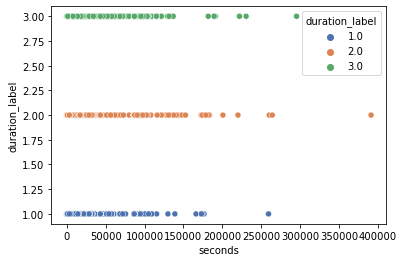

In [48]:
fig,ax = plt.subplots()

sns.scatterplot(data=data[['seconds', 'duration_label']], x="seconds", y="duration_label", hue="duration_label", palette="deep")

In [94]:
#Why are there outliers?
print(data.iloc[33090].steps)
data.loc[data['seconds']>350000]

['sift flours , baking soda , baking powder and salt into a bowl', 'set aside', 'using a mixer fitted with paddle attachment , cream butter and sugars together until very light , about 5 minutes', 'add eggs , one at a time , mixing well after each addition', 'stir in the vanilla', 'reduce speed to low , add dry ingredients and mix until just combined , 5 to 10 seconds', 'drop chocolate pieces in and incorporate them without breaking them', 'press plastic wrap against dough and refrigerate for 24 to 36 hours', 'dough may be used in batches , and can be refrigerated for up to 72 hours', 'when ready to bake , preheat oven to 350 degrees', 'line a baking sheet with parchment paper or a nonstick baking mat', 'set aside', 'scoop 6 3 1 / 2-ounce mounds of dough onto baking sheet , making sure to turn horizontally any chocolate pieces that are poking up', 'it will make for a more attractive cookie', 'sprinkle lightly with sea salt and bake until golden brown but still soft , 18 to 20 minutes',

name  n_steps  \
33090  chocolate chip cookies adapted from jacques to...       19   

       n_ingredients                                              steps  \
33090             12  ['sift flours , baking soda , baking powder an...   

                                             ingredients  duration_label  \
33090  ['cake flour', 'bread flour', 'baking soda', '...             2.0   

        seconds  
33090  390910.0

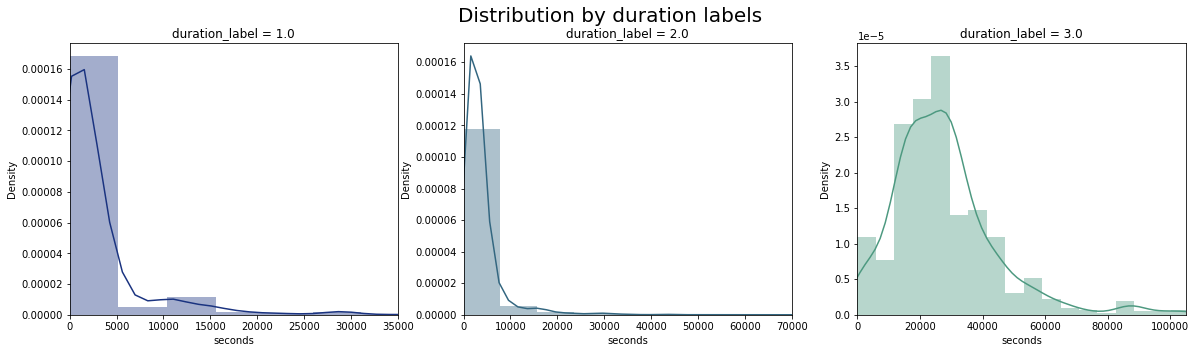

In [96]:
warnings.simplefilter("ignore", category=FutureWarning)
fig,ax = plt.subplots(1,3, figsize=(20,5))
fig.suptitle('Distribution by duration labels',size=20)
for i, data_small in data.groupby('duration_label'):
    #data_small['seconds'].hist(density=True, alpha=0.7, ax=ax[int(i-1)], label=i)
    sns.distplot(data_small['seconds'],kde=True, hist=True, ax=ax[int(i-1)], label=i, color=(0.1*i,0.2*i,0.5))
    ax[int(i-1)].set_xlim([0,35000*i])
    ax[int(i-1)].set_title("duration_label = "+str(i))
    ax[int(i-1)].set_xlabel('seconds')

In [98]:
print(np.mean(data.loc[data['duration_label']==1.0]['seconds']))
print(np.mean(data.loc[data['duration_label']==2.0]['seconds']))
print(np.mean(data.loc[data['duration_label']==3.0]['seconds']))
data['steps'].iloc[39995]

3871.757028262988
4458.735886481538
28746.274963108706


'[\'in a measuring cup , combine sour cream and lemon juice\', \'add enough of the milk to make 1 / 2 cup\', "place all bread ingredients in bread machine according to your manufacturer\'s directions", \'select sweet bread or basic setting\', \'do not use timer delay for this recipe\', \'for spread , beat all ingredients together until smooth\']'

In [109]:
# Evaluate this new feature
train_data = data.loc[:,['n_steps','n_ingredients','seconds','steps','duration_label']]

# Why is the time missing?
missing_time_data = train_data.loc[np.isnan(train_data['seconds'])]
print(Counter(missing_time_data['duration_label']))

# How did the steps for different lengths look like, given that no timing is found?
long_missing = missing_time_data.loc[missing_time_data['duration_label']==3, ['steps']]
#long_missing.head(10)
[[print(s) for s in long_missing.iloc[i]] for i in range(10)]

Counter({1.0: 4356, 2.0: 513, 3.0: 16})
['cook on light cycle in your bread maker machine']
['for the artichoke hearts i have used either the jarred marinated or frozen hearts-thawed', 'make the cocktail dressing first by combining the mayonnaise , chili sauce , parsley , worcestershire , and black pepper', 'cover and chill', 'cut grapefruits in half', 'remove the fruit segments with a serrated spoon', 'cut the fruit segments up into bite sized pieces and toss with the lemon juice', 'clean out the grapefruit shells and remove pith', 'set aside', 'in a bowl gently mix the grapefruit , shrimp , cayenne and rum', 'cut the marinated artichokes up into bite sized pieces and combine with the grapefruit / shrimp mixture', 'if using frozen artichoke hearts , squeeze out the excess moisture gently with your hands', 'divide the mixture and spoon into the grapefruit shells', 'divide and spoon the cocktail dressing on top of each grapefruit shell', 'garnish with lemon slices and fresh parsley', 's

[[None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None]]

## Test basic models on data with seconds feature

In [13]:
# We'll fix it later. For now, let's try and predict with the existing values first
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer


train_data = data.loc[np.isnan(data['seconds']) == False,['n_steps','n_ingredients','seconds','duration_label']]
Xseconds = data.loc[np.isnan(data['seconds']) == False,['seconds']]
X=train_data.iloc[:,:-1]
Y=train_data.iloc[:,-1]

#imp = IterativeImputer(max_iter=10, random_state=0)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X)

X_test = test_data.reindex(columns=['n_steps','n_ingredients','seconds'])
X_test = imp.transform(X_test)

models = [DummyClassifier(strategy='most_frequent'),
            GaussianNB(),
            MultinomialNB(),
            #LinearSVC(max_iter=10000, random_state=0),
            DecisionTreeClassifier(),
            KNeighborsClassifier(),
            LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10000)]

titles = ['0r',
          'nb',
          'multinomial_nb',
          #'LinearSVC',
          'decision_tree',
          'knn',
          'logistic_regression']

for title, model in zip(titles, models):
    start = time.time()
    model.fit(X,Y)
    Y_test = model.predict(X_test)
    out = pd.DataFrame({'duration_label':Y_test})
    out.index += 1
    out.to_csv('output/out_'+title+'.csv',index_label = 'id')
    accuracy = np.mean(cross_val_score(model,X,Y,cv=10))
    runtime = time.time() - start
    print(f'Model {title:s} has accuracy of {accuracy*100:2.2f}%, runtime {runtime:3.2f} seconds')

Model 0r has accuracy of 56.20%, runtime 0.07 seconds
Model nb has accuracy of 58.67%, runtime 0.13 seconds
Model multinomial_nb has accuracy of 55.45%, runtime 0.14 seconds
Model decision_tree has accuracy of 71.36%, runtime 0.57 seconds
Model knn has accuracy of 73.62%, runtime 2.33 seconds
Model logistic_regression has accuracy of 57.23%, runtime 6.91 seconds


## Data visualization

In [70]:
curr_dir = os.path.dirname(os.path.realpath('__file__'))
train_file = os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\recipe_train.csv')

data = pd.read_csv(train_file, index_col = False, delimiter = ',')

In [22]:
# check for missing value
data.count()

name              40000
n_steps           40000
n_ingredients     40000
steps             40000
ingredients       40000
duration_label    40000
dtype: int64

Text(0, 0.5, 'Frequency')

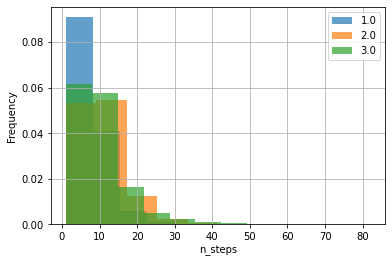

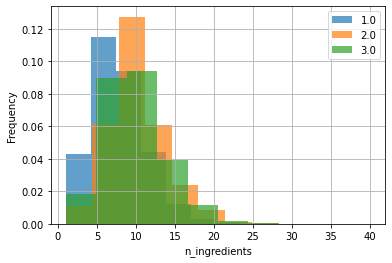

In [97]:
fig,ax = plt.subplots()
for i, data_small in data.groupby('duration_label'):
    data_small['n_steps'].hist(density=True, alpha=0.7, ax=ax, label=i)
ax.legend()
ax.set_xlabel('n_steps')
ax.set_ylabel('Frequency')

fig,ax = plt.subplots()
for i, data_small in data.groupby('duration_label'):
    data_small['n_ingredients'].hist(density=True, alpha=0.7, ax=ax, label=i)
ax.legend()
ax.set_xlabel('n_ingredients')
ax.set_ylabel('Frequency')

<AxesSubplot:xlabel='n_steps', ylabel='n_ingredients'>

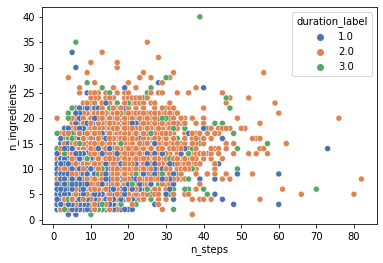

In [5]:
numeric_data = data[['n_steps', 'n_ingredients', 'duration_label']]

y = data['duration_label']

sns.scatterplot(data=numeric_data, x="n_steps", y="n_ingredients", hue="duration_label", palette="deep")

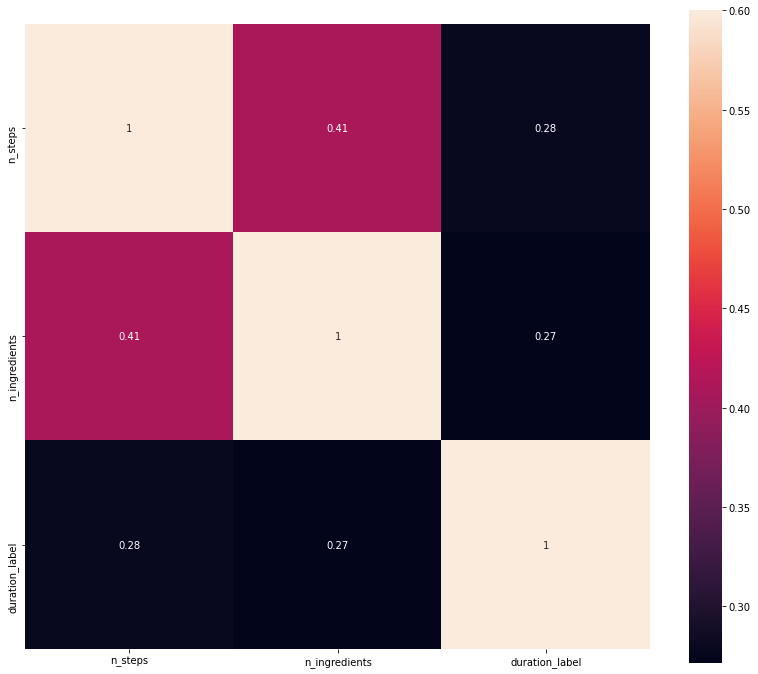

In [24]:
plt.figure(figsize=(14,12))
# foo = sns.heatmap(data.drop('PassengerId',axis=1).corr(), vmax=0.6, square=True, annot=True)
foo = sns.heatmap(data[['n_steps', 'n_ingredients', 'duration_label']].corr(), vmax=0.6, square=True, annot=True)

## Part 1: Single model training and evaluation

## Part 2: Classifier combination training and evaluation